In [1]:
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv('train.csv')

In [ ]:
# graph for this

# The first listed diagnosis (DGNSCD01) is typically the main reason for hospital admission or the condition requiring the most resources.
# Why It Matters: The primary diagnosis often has the greatest impact on readmission risk.

In [55]:
df.head()

,ID,STAY_DRG_CD,STAY_FROM_DT,STAY_THRU_DT,STUS_CD,TYPE_ADM,SRC_ADMS,AD_DGNS,DGNSCD01,PRCDRCD01,...,PRCDRCD22,DGNSCD23,PRCDRCD23,DGNSCD24,PRCDRCD24,DGNSCD25,PRCDRCD25,stay_drg_cd,Readmitted_30,proc_matches_diag
0,17319,NaN,2017-12-13 00:00:00,2017-12-20 00:00:00,62,1,2,M25551,S72001A,0SRR01Z,...,NaN,Z86711,NaN,Z86718,NaN,Z85828,NaN,469,0,True
1,19722,NaN,2017-10-19 00:00:00,2017-10-23 00:00:00,1,1,1,R531,A419,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,871,1,True
2,89699,NaN,2018-08-06 00:00:00,2018-08-08 00:00:00,1,1,1,R002,J690,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177,0,True
3,8086,NaN,2016-12-20 00:00:00,2016-12-27 00:00:00,62,5,1,K661,K661,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,393,0,True
4,68049,NaN,2016-01-06 00:00:00,2016-01-12 00:00:00,6,1,1,J9601,J690,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177,0,True


In [ ]:
df['Readmitted_30'].value_counts() # class imbalance is detected

Readmitted_30
0    103598
1     26698
Name: count, dtype: int64

In [ ]:
nulls = df.isna().sum()

Trows = df.shape[0] # number of rows in the dataset


# sort the nulls in descending order
nulls = nulls[nulls > 0].sort_values(ascending=False)
for i in nulls.index:
    if nulls[i] > 0:
        print(f"{i} has {(nulls[i]/Trows)*100}% null values")



STAY_DRG_CD has 97.08509854485172% null values
PRCDRCD25 has 96.63228341622153% null values
PRCDRCD24 has 96.62384110026402% null values
PRCDRCD23 has 96.61616626757537% null values
PRCDRCD22 has 96.60542150181126% null values
PRCDRCD21 has 96.59467673604716% null values
PRCDRCD20 has 96.58162952047645% null values
PRCDRCD19 has 96.5655123718303% null values
PRCDRCD18 has 96.54172039049548% null values
PRCDRCD17 has 96.51869589242953% null values
PRCDRCD16 has 96.48339166206176% null values
PRCDRCD15 has 96.43273776631669% null values
PRCDRCD14 has 96.34524467366612% null values
PRCDRCD13 has 96.24623933198257% null values
PRCDRCD12 has 96.11346472646896% null values
PRCDRCD11 has 95.93387364155461% null values
PRCDRCD10 has 95.66909191379628% null values
PRCDRCD09 has 95.36056363971267% null values
PRCDRCD08 has 94.89393381224289% null values
PRCDRCD07 has 94.14180020875544% null values
PRCDRCD06 has 92.49324614723399% null values
PRCDRCD05 has 90.2445201694603% null values
PRCDRCD04 

In [28]:
# count coulmns greater than 50% null values
nulls_50 = nulls[nulls > (Trows*0.5)]
print(f"Columns with more than 50% null values: {len(nulls_50)}")
# count coulmns greater than 50% null values
nulls_60 = nulls[nulls > (Trows*0.6)]
print(f"Columns with more than 60% null values: {len(nulls_60)}")
# count coulmns greater than 70% null values
nulls_70 = nulls[nulls > (Trows*0.7)]
print(f"Columns with more than 70% null values: {len(nulls_70)}")
# count coulmns greater than 80% null values
nulls_80 = nulls[nulls > (Trows*0.8)]
print(f"Columns with more than 80% null values: {len(nulls_80)}")

Columns with more than 50% null values: 33
Columns with more than 60% null values: 31
Columns with more than 70% null values: 28
Columns with more than 80% null values: 25


### relation in procedure occurance

In [31]:
# Function to check if procedures follow the pattern you described
def check_procedure_pattern(row):
    """
    Checks if procedures follow the pattern:
    If procedure n is missing, then all procedures n+1 to 25 are also missing
    Returns True if pattern holds, False otherwise
    """
    proc_columns = [f'PRCDRCD{str(i).zfill(2)}' for i in range(1, 26)]
    first_empty = None
    
    for i, col in enumerate(proc_columns):
        if pd.isna(row[col]) or row[col] == '' : # or row[col] == '-'
            first_empty = i
            break
    
    if first_empty is None:  # All procedures are filled
        return True
    
    # Check if all procedures after first_empty are also empty
    for col in proc_columns[first_empty:]:
        if not pd.isna(row[col]) and row[col] != '':
            return False
    
    return True

Procedure Pattern Compliance:
follows_pattern
True    130296
Name: count, dtype: int64
Percentage of rows following pattern: 100.00%

Procedure count statistics:
count    130296.000000
mean          2.007690
std           4.743382
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          25.000000
Name: proc_count, dtype: float64


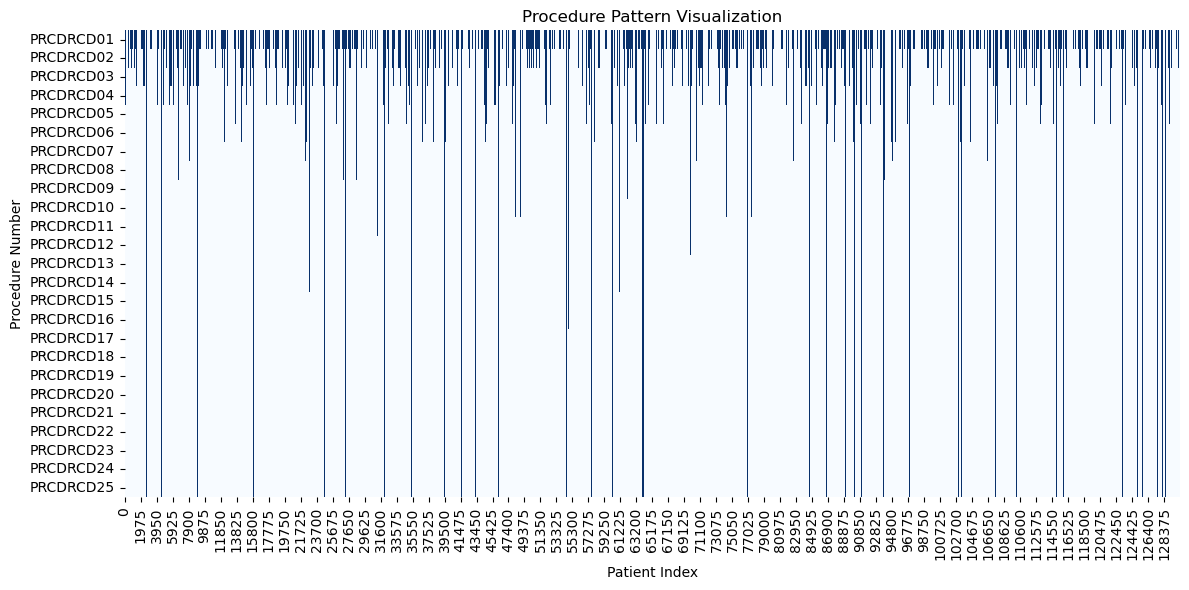

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

df_temp  = df.copy()

# Apply the function to each row
df_temp['follows_pattern'] = df_temp.apply(check_procedure_pattern, axis=1)

# Count pattern compliance
pattern_count = df_temp['follows_pattern'].value_counts()
print("Procedure Pattern Compliance:")
print(pattern_count)
print(f"Percentage of rows following pattern: {100 * pattern_count.get(True, 0) / len(df_temp):.2f}%")

# Visualize procedure presence
# Create a matrix where 1 means procedure exists, 0 means not exists
proc_presence = pd.DataFrame()
for i in range(1, 26):
    col = f'PRCDRCD{str(i).zfill(2)}'
    proc_presence[col] = (~df_temp[col].isna() & (df_temp[col] != '')).astype(int)

# Count number of procedures per row
df_temp['proc_count'] = proc_presence.sum(axis=1)
print("\nProcedure count statistics:")
print(df_temp['proc_count'].describe())

# Visualize the procedure pattern
plt.figure(figsize=(12, 6))
sns.heatmap(proc_presence.T, cmap='Blues', cbar=False)
plt.title('Procedure Pattern Visualization')
plt.xlabel('Patient Index')
plt.ylabel('Procedure Number')
plt.tight_layout()
plt.savefig('procedure_pattern.png')


In [33]:
# as procedure is following pattern we can concatenate the columns into one column that indicates that how many procedures are done 

4399

In [35]:



# Check if procedures always have a corresponding diagnosis
proc_diag_match = pd.DataFrame()
for i in range(1, 26):
    proc_col = f'PRCDRCD{str(i).zfill(2)}'
    diag_col = f'DGNSCD{str(i).zfill(2)}'
    
    # 1 if procedure exists but diagnosis doesn't, 0 otherwise
    proc_diag_match[f'proc_{i}_no_diag'] = ((~df_temp[proc_col].isna() & (df_temp[proc_col] != '')) & 
                                           (df_temp[diag_col].isna() | (df_temp[diag_col] == ''))).astype(int)

# Check if any procedures exist without corresponding diagnosis
has_proc_without_diag = proc_diag_match.sum(axis=1) > 0
proc_without_diag_count = has_proc_without_diag.sum()

print(f"\nRows with procedures without corresponding diagnosis: {proc_without_diag_count}")
print(f"Percentage: {100 * proc_without_diag_count / len(df_temp):.2f}%")



Rows with procedures without corresponding diagnosis: 247
Percentage: 0.19%


In [48]:
df.shape

(130296, 61)

## diagnosis


In [54]:
# get all unique diagnosis codes
unique_diagnosis_codes = set()
all_diagnosis_codes = []
for i in range(1, 26):
    col = f'DGNSCD{str(i).zfill(2)}'
    unique_diagnosis_codes.update(df[col].dropna().unique())
    all_diagnosis_codes.extend(df[col].dropna())

print(f"Total unique diagnosis codes: {len(unique_diagnosis_codes)}")
print(f"all diagnosis codes: {len(all_diagnosis_codes)}")
# get all unique diagnosis codes
unique_procedure_codes = set()
all_procedure_codes = []
for i in range(1, 26):
    col = f'PRCDRCD{str(i).zfill(2)}'
    unique_procedure_codes.update(df[col].dropna().unique())
    all_procedure_codes.extend(df[col].dropna())

print(f"Total unique procedure codes: {len(unique_procedure_codes)}")
print(f"all procedures codes: {len(all_procedure_codes)}")
print(len(unique_diagnosis_codes)/len(all_procedure_codes))

Total unique diagnosis codes: 9779
all diagnosis codes: 2288123
Total unique procedure codes: 4702
all procedures codes: 261594
0.037382355864431144


In [36]:
# Part 1: Check if diagnosis columns follow the same sequential pattern
def check_diagnosis_pattern(row):
    """
    Checks if diagnoses follow the pattern:
    If diagnosis n is missing, then all diagnoses n+1 to 25 are also missing
    Returns True if pattern holds, False otherwise
    """
    diag_columns = [f'DGNSCD{str(i).zfill(2)}' for i in range(1, 26)]
    first_empty = None
    
    for i, col in enumerate(diag_columns):
        if pd.isna(row[col]) or row[col] == '':
            first_empty = i
            break
    
    if first_empty is None:  # All diagnoses are filled
        return True
    
    # Check if all diagnoses after first_empty are also empty
    for col in diag_columns[first_empty:]:
        if not pd.isna(row[col]) and row[col] != '':
            return False
    
    return True

In [37]:
df_temp['diag_follows_pattern'] = df_temp.apply(check_diagnosis_pattern, axis=1)


In [39]:


# Apply the function to each row

# Count pattern compliance for diagnoses
diag_pattern_count = df_temp['diag_follows_pattern'].value_counts()
print("Diagnosis Pattern Compliance:")
print(diag_pattern_count)
print(f"Percentage of rows following diagnosis pattern: {100 * diag_pattern_count.get(True, 0) / len(df_temp):.2f}%")

# Visualize diagnosis presence
diag_presence = pd.DataFrame()
for i in range(1, 26):
    col = f'DGNSCD{str(i).zfill(2)}'
    diag_presence[col] = (~df_temp[col].isna() & (df_temp[col] != '')).astype(int)

# Count number of diagnoses per row
df_temp['diag_count'] = diag_presence.sum(axis=1)
print("\nDiagnosis count statistics:")
print(df_temp['diag_count'].describe())



Diagnosis Pattern Compliance:
diag_follows_pattern
True    130296
Name: count, dtype: int64
Percentage of rows following diagnosis pattern: 100.00%

Diagnosis count statistics:
count    130296.000000
mean         17.560961
std           5.761980
min           1.000000
25%          13.000000
50%          18.000000
75%          23.000000
max          25.000000
Name: diag_count, dtype: float64
